<div style="background-color: #E87A00; color: #fff; padding: 20px; border-radius: 10px; text-align: center;">
    <h2 style="margin-bottom: 10px;">Welcome to my Notebook</h2>
</div>

# Table of Content

* [Data Cleaning and Preparation](#section-1)
* [Explorary Data analysis(EDA)](#section-2)
* [Feature Engeneering](#section-3)
* [Training Prediction Model](#section-4)

## Data Selection
### Selected Columns:

- **id**
  - Only used for data cleaning; will not be used for price prediction.
- **host_id**
  - Only used for data cleaning; will not be used for price prediction.
- **host_is_superhost**
- **host_listing_count**
- **zipcode**
- **latitude**
  - Only used for EDA (Exploratory Data Analysis) and visualization; we will use zip code instead in the price prediction.
- **longitude**
  - Only used for EDA and visualization; we will use zip code instead in the price prediction.
- **property_type**
- **room_type**
- **accommodates**
- **neighbourhood**
- **bathrooms**
- **bedrooms**
- **beds**
- **amenities**
- **price**
- **minimum_nights**
- **has_availability**
- **availability_30**
- **availability_60**
- **availability_90**
- **availability_365**
- **number_of_reviews_ltm**
- **review_scores_rating**


### Dropped Columns:

- **listing_url**
  - Can be useful to scrape more data from the Airbnb website, but it's against the website's terms of service.
- **name**
- **summary**
  - Using this column would make the model more complicated because we would need to analyze the text using other language models.
- **space**
  - Same reason as above.
- **description**
- **neighborhood_overview**
- **access**
- **picture_url**
- **host_url**
- **host_name**
- **host_response_time**
  - Removed based on our hypothesis that the host has good response time and rate, which will improve our model.
- **host_response_rate**
- **host_picture_url**
- **host_neighbourhood**
- **host_listings_count**
- **host_verifications**
- **host_has_profile_pic**
- **host_identity_verified**
- **street**
- **host_since**
- **neighbourhood_cleansed**
- **neighbourhood_group_cleansed**
- **city**
  - The only value in this column is 'Barcelona', which will have no effect on our prediction.
- **country**
  - The only value in this column is 'Spain', which will have no effect on our prediction.
- **is_location_exact**
- **cleaning_fee**
  - Dropped based on our hypothesis that the cleaning fee is low compared to the price.
- **maximum_nights**
- **last_review**
- **review_scores_accuracy**
- **review_scores_cleanliness**
- **review_scores_checkin**
- **review_scores_communication**
- **review_scores_location**
- **instant_bookable**

### Dropped columns because they have too many NAN values
- **square_feet**
- **first_review**
- **review_scores_rating**
- **review_score_location**
- **review_scores_value**
- **reviews_per_month**

# Data Cleaning and Preparation <a id="section-1"></a>

Clean and preprocess the data using Python to handle missing values, outliers, and data inconsistencies.

#### - **We will clean based on some hypotheses:**
- The host has a 100% response rate.
- The host is verified.
- The host has a small cleaning fee compared to the price, which will not affect the customer's decision.
- The host's name, picture, and ethnicity have no effect on the listing performance.

In [1]:
#lets import our libraries that we gonna use first

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import math
import plotly.express as px

#setting matplotlib style

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style('darkgrid')

In [2]:
#loading data frames from csv files that we have
used_columns = [
    'id',
    'host_id',
    'host_is_superhost',
    'host_listings_count',
    'zipcode',
    'latitude',
    'longitude',
    'property_type',
    'room_type',
    'accommodates',
    'neighbourhood',
    'bathrooms',
    'bedrooms',
    'beds',
    'amenities',
    'price',
    'minimum_nights',
    'has_availability',
    'availability_30',
    'availability_60',
    'availability_90',
    'availability_365',
    'number_of_reviews_ltm',
    'review_scores_rating'
    
]

listing=pd.read_csv('/kaggle/input/barcelona-airbnb-listings-inside-airbnb/barcelona_listings.csv',usecols=used_columns, low_memory=False)
data_lenght=len(listing)

In [3]:
for col in listing.columns:
    nan_values=len(listing[col][listing[col].isnull()])
    if nan_values>0:
        print( col + ' has number of NAN:', nan_values )

host_is_superhost has number of NAN: 34
host_listings_count has number of NAN: 34
neighbourhood has number of NAN: 10
zipcode has number of NAN: 604
bathrooms has number of NAN: 9
bedrooms has number of NAN: 3
beds has number of NAN: 34
review_scores_rating has number of NAN: 4847


In [4]:

#let's remove NAN values in our dataset since they are very small ad won't affect our result
listing=listing.dropna(how='any', subset=['zipcode', 'host_is_superhost', 'bedrooms', 'beds', 'bathrooms','host_listings_count','neighbourhood'])


#removing rows that are false data like rows where the beds are 0

listing=listing[~(listing['beds']==0)]
listing=listing[~(listing['bedrooms']==0)]

#changing numeric values to right data type
listing['price'] = listing['price'].replace('[\$,]', '', regex=True).astype(float)




print('we successfully removed {} rows, and kept {} clean rows'.format(data_lenght-len(listing),len(listing)))

we successfully removed 1385 rows, and kept 18448 clean rows


### Cleaning Zipcode Column

In the *zipcode* column, there are mixed records consisting of both floats and strings with various formats, including duplicates like **08140814** or formats such as **14-08585**, as well as entries with only *4 digits* like *8653*.

Since all Barcelona zip codes start with *08* and are *five digits* long, we can search for the number _8_ and verify that it is followed by _three digits_. This will confirm that it represents the end of the zip code. By appending a _0_ before it, we can obtain the complete zip code.


In [5]:
def extract_4_digit_sequence(text):
    # Define a regex pattern to match '8' followed by exactly 3 digits
    text=str(text)
    pattern = r'8\d{3}'  # Matches '8' followed by exactly 3 digits
    matches = re.findall(pattern, text)
    if len(matches)>0:
        return '0'+matches[0]
    else:
        return np.nan

listing['zipcode']=listing['zipcode'].apply(extract_4_digit_sequence)

#removing nan columns that dont have valid zipcode 

listing=listing[~listing['zipcode'].isna()]

#reseting the index after dropping rows
listing.reset_index(drop=True, inplace=True)

### handling NAN values in review score

*let's analys the NAN columns to see why we have missing data*

In [6]:
listing[listing['review_scores_rating'].isna()]['number_of_reviews_ltm'].value_counts()

number_of_reviews_ltm
0    4340
1     109
2      11
3       5
8       2
Name: count, dtype: int64

**We observed that most missing reviews indicate no reviews for those listings. To address this, we will replace these missing values with 'No Review' instead of NaN. Additionally, we will convert the column values to string type to treat them as categorical data, allowing us to account for new listings with no reviews.**

In [7]:
#first we gonna fill NaN values to 'no reviews'
listing['review_scores_rating'].fillna('no reviews', inplace=True)

#then we have to change the numerical values to a categorical data

def categorie(number):
    if number=='no reviews':
        return number
    if 0 <= number < 10:
        return '0-9'
    elif 10 <= number < 20:
        return '10-19'
    elif 20 <= number < 30:
        return '20-29'
    elif 30 <= number < 40:
        return '30-39'
    elif 40 <= number < 50:
        return '40-49'
    elif 50 <= number < 60:
        return '50-59'
    elif 60 <= number < 70:
        return '60-69'
    elif 70 <= number < 80:
        return '70-79'
    elif 80 <= number < 90:
        return '80-89'
    elif 90 <= number <= 100:
        return '90-100'
    else:
        return 'no reviews'
    

listing['review_scores_rating']=listing['review_scores_rating'].apply(categorie)
listing['review_scores_rating']

/tmp/ipykernel_115/3394338287.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  listing['review_scores_rating'].fillna('no reviews', inplace=True)
/tmp/ipykernel_115/3394338287.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'no reviews' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  listing['review_scores_rating'].fillna('no reviews', inplace=True)


0             80-89
1             80-89
2            90-100
3            90-100
4            90-100
            ...    
18424    no reviews
18425    no reviews
18426    no reviews
18427    no reviews
18428    no reviews
Name: review_scores_rating, Length: 18429, dtype: object

### searching for outliers

In [8]:
grouped_beds = listing.groupby('beds').agg(
    median_price=('price', 'median'), 
    listing_count=('price', 'count')   
).reset_index()

grouped_beds

,beds,median_price,listing_count
0,1.0,44.0,8816
1,2.0,70.0,3461
2,3.0,100.0,2430
3,4.0,120.0,1762
4,5.0,129.0,882
5,6.0,170.0,589
6,7.0,190.0,195
7,8.0,220.0,109
8,9.0,352.0,52
9,10.0,250.0,51


It's evident that the data points for accommodations with 28 and 40 beds have unusually low prices and only a single listing each, indicating that they are outliers. To ensure the accuracy of our predictions, it's necessary to remove these outliers from the dataset.

In [10]:
listing = listing[~listing['beds'].isin([28,40])]

In [11]:
grouped_bedrooms = listing.groupby('bedrooms').agg(
    median_price=('price', 'median'), 
    listing_count=('price', 'count')   
).reset_index()

grouped_bedrooms

,bedrooms,median_price,listing_count
0,1.0,48.0,11433
1,2.0,99.0,3834
2,3.0,127.0,2233
3,4.0,170.0,694
4,5.0,250.0,127
5,6.0,350.0,68
6,7.0,296.5,10
7,8.0,390.0,7
8,9.0,450.0,8
9,10.0,425.0,9


Same for this case we notice that data points for accommodations with 11 bedrooms and 16 berooms have unusually low prices and only a single listing each, indicating that they are outliers. To ensure the accuracy of our predictions, it's necessary to remove these outliers from the dataset.

In [12]:
listing = listing[~listing['bedrooms'].isin([11,16])]



# Exploratory Data Analysis (EDA)<a id="section-2"></a>

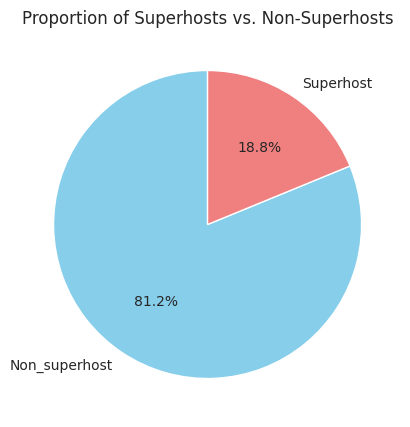

In [15]:
superhost_counts = listing['host_is_superhost'].value_counts()

# Plotting the pie chart
plt.figure(figsize=[5, 5])
plt.pie(superhost_counts, labels=['Non_superhost','Superhost'], autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightcoral'])
plt.title('Proportion of Superhosts vs. Non-Superhosts')

plt.show()




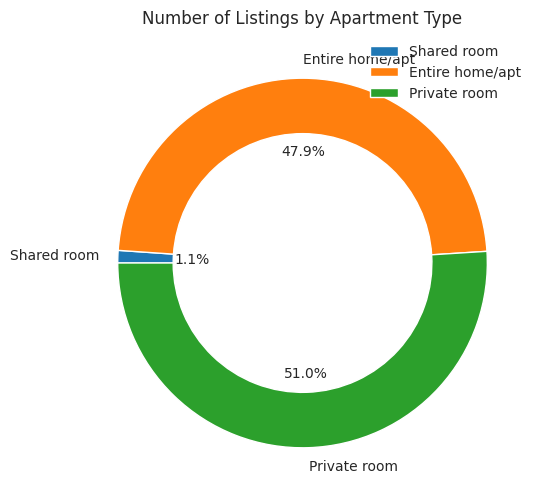

In [16]:
apt_type_df=pd.DataFrame(listing['room_type'].value_counts()).reset_index().sort_values('count')
apt_type_df['avg_price']=listing.groupby('room_type')['price'].mean().reset_index()['price']
apt_type_df['avg_number_reviews_ltm']=listing.groupby('room_type')['number_of_reviews_ltm'].mean().reset_index()['number_of_reviews_ltm']

plt.figure(figsize=[8,6])
plt.pie(apt_type_df['count'],labels=apt_type_df['room_type'], autopct='%1.1f%%', startangle=180, counterclock=False, wedgeprops=dict(width=0.3))


plt.title('Number of Listings by Apartment Type')
plt.legend()





plt.show()

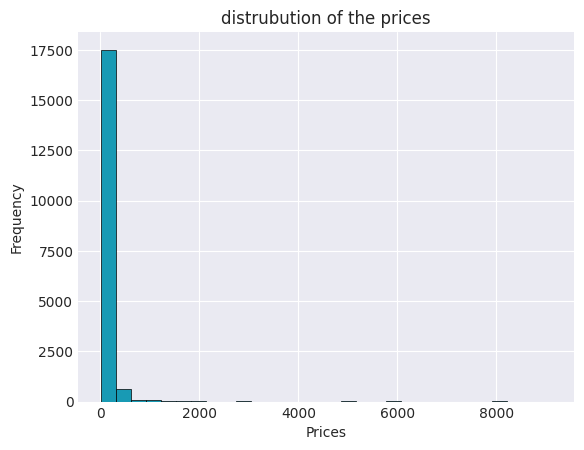

In [17]:
#visualisation of the distrubution of prices to see the market competitions
plt.hist(listing['price'],color='#189AB4', bins=30,edgecolor='black',linewidth=0.5)
plt.title('distrubution of the prices')
plt.xlabel('Prices')
plt.ylabel('Frequency')
plt.show()

### **Observation**
*We observe that the price distribution is skewed to the right due to several factors, including the presence of special listings with high prices and intense competition in the $0 to $500 price range. To address this skewness and make our visualization more informative, we will apply a normalization method. In our analysis, the logarithmic transformation appears to be the most suitable method to achieve a more balanced distribution of prices.*

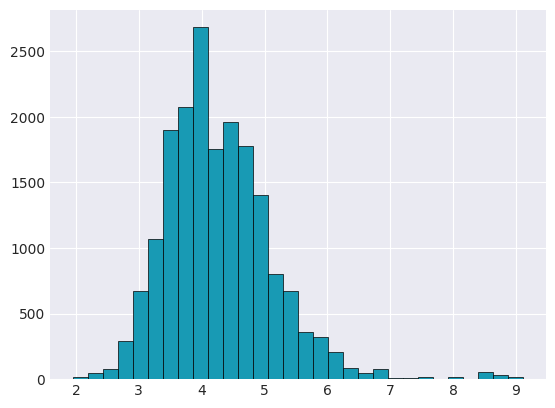

In [18]:
#creating new column for the normalized price to get a normal distribution
 
listing['price_normal']=listing['price'].apply(math.log)
plt.hist(listing['price_normal'],color='#189AB4', bins=30,edgecolor='black',linewidth=0.5)
plt.show()

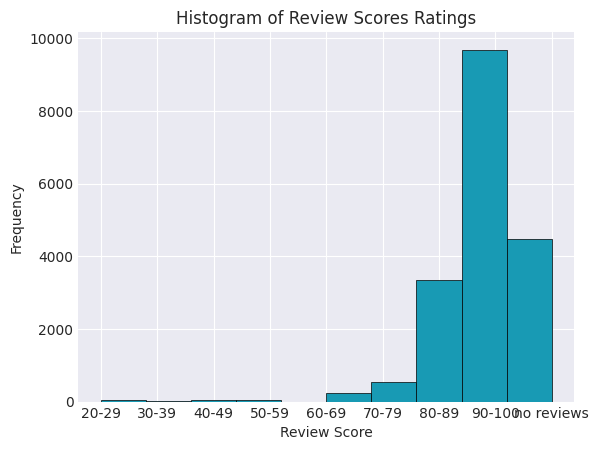

In [19]:
data=listing['review_scores_rating']
plt.hist(data.sort_values(),color='#189AB4', bins=10,edgecolor='black',linewidth=0.5)
plt.title("Histogram of Review Scores Ratings")
plt.xlabel("Review Score")
plt.ylabel("Frequency")
plt.show()


### **Observation**
*We observe from this visualization that the distribution tends towards the right. This trend can be attributed to the fact that most reviews are left by highly satisfied guests who are more likely to share positive feedback about their experience. Therefore, a higher number of reviews typically indicates a well-regarded host and property.*

### Heatmap

*Let's begin by plotting a heatmap of the numerical values to identify any columns with strong correlations, which will guide further investigation.*

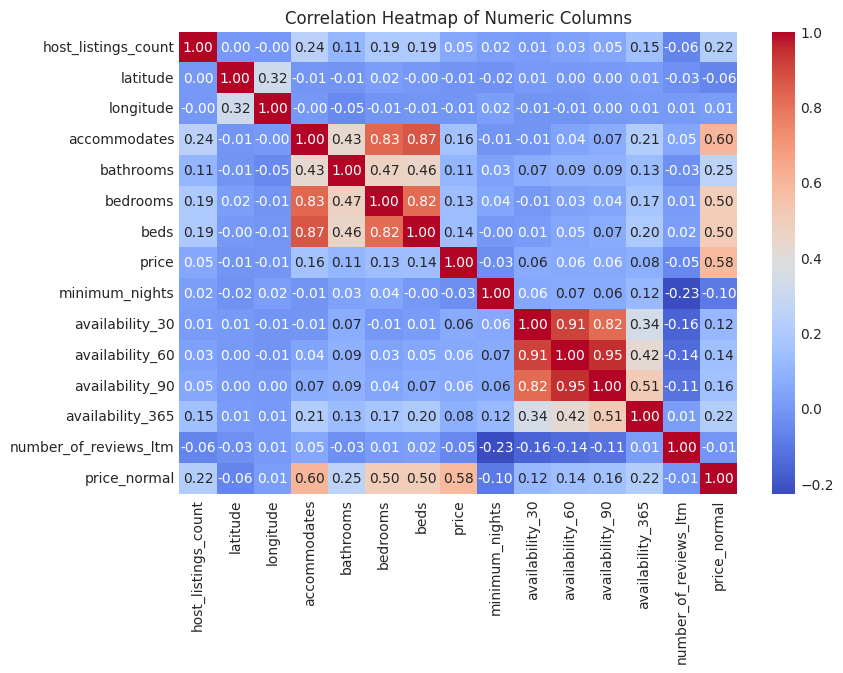

In [20]:
numeric_columns = listing.drop(columns=['id','host_id']).select_dtypes(include=['int', 'float']).columns

# Create heatmap using numeric columns
plt.figure(figsize=[9,6])
sns.heatmap(listing[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

### Conclusion

Based on the heatmap, we identified three significant correlations that are relevant to our analysis:

    -   Accommodates vs. Normalized Price
    -   Beds vs. Normalized Price
    -   Bedrooms vs. Normalized Price

These correlations will be instrumental in our further exploration and understanding of the dataset.



### Accommodates vs Price

*First, let's plot the median price for each accommodation capacity. We're using the median instead of the mean because higher accommodation capacities may include listings with very low prices compared to others with the same capacity. The median is less affected by outliers, providing a more robust measure of central tendency in this context.*

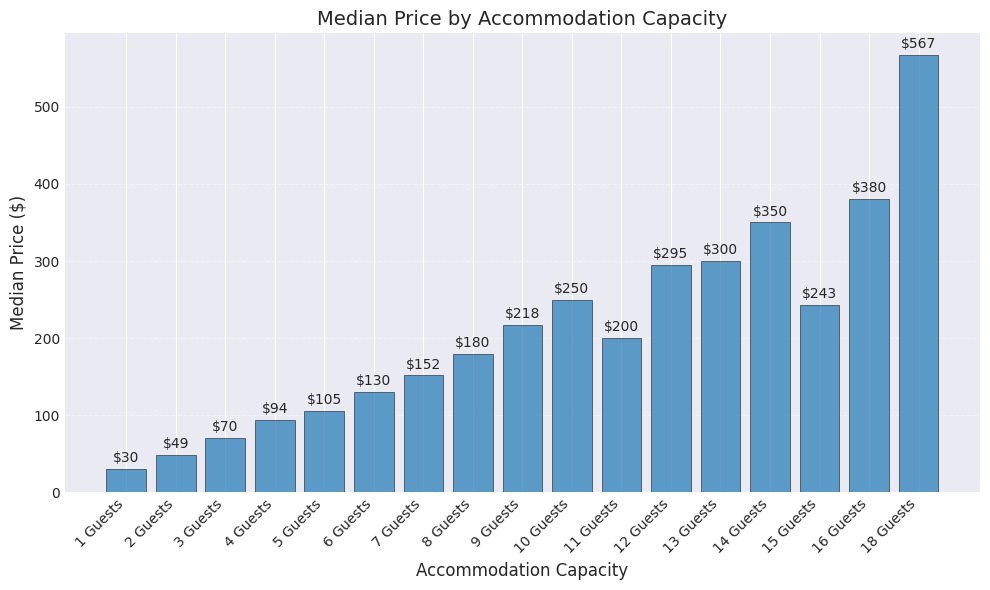

In [21]:

data=listing.groupby('accommodates')['price'].median()
accommodates=listing['accommodates'].apply(str).unique()


plt.figure(figsize=[10, 6])
plt.bar(accommodates, data.values, alpha=0.7,edgecolor='black',linewidth=0.5)


plt.title('Median Price by Accommodation Capacity', fontsize=14)
plt.xlabel('Accommodation Capacity', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)


plt.xticks(accommodates, [str(x) + ' Guests' for x in data.index], rotation=45, ha='right', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, v in enumerate(data.values):
    plt.text(i, v+5, '${:.0f}'.format(v), ha='center', va='bottom', fontsize=10)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.tight_layout() 
plt.show()

### Conclusion

*We conclude that the price tends to rise with increasing accommodation capacity, which is expected. We will take this relationship into consideration in our prediction model.*

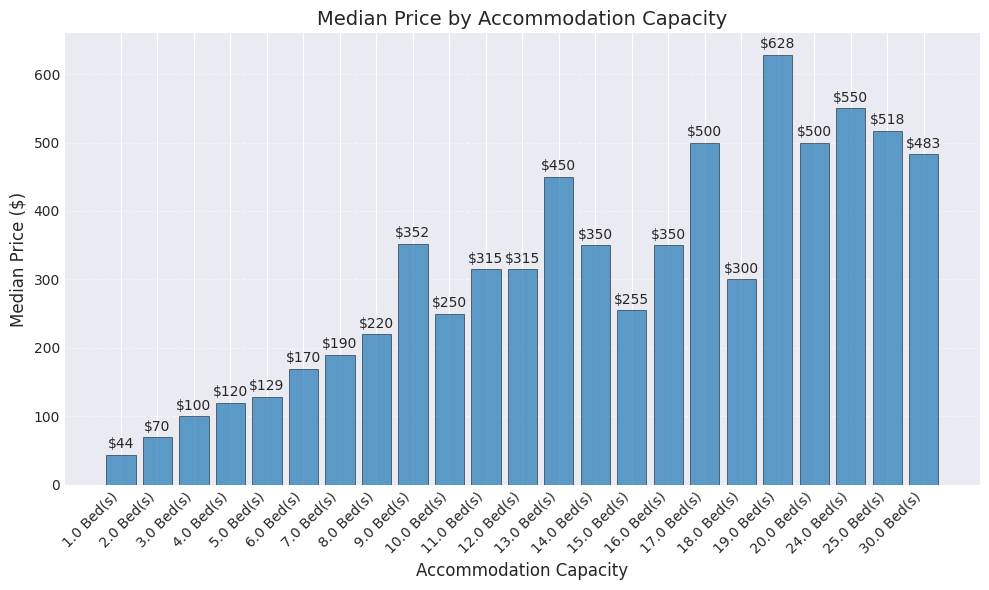

In [22]:
data=listing.groupby('beds')['price'].median()
beds=listing['beds'].apply(str).unique()


plt.figure(figsize=[10, 6])
plt.bar(beds, data.values, alpha=0.7, edgecolor='black',linewidth=0.5)


plt.title('Median Price by Accommodation Capacity', fontsize=14)
plt.xlabel('Accommodation Capacity', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)


plt.xticks(beds, [str(x) + ' Bed(s)' for x in data.index], rotation=45, ha='right', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, v in enumerate(data.values):
    plt.text(i, v+5, '${:.0f}'.format(v), ha='center', va='bottom', fontsize=10)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.tight_layout() 
plt.show()

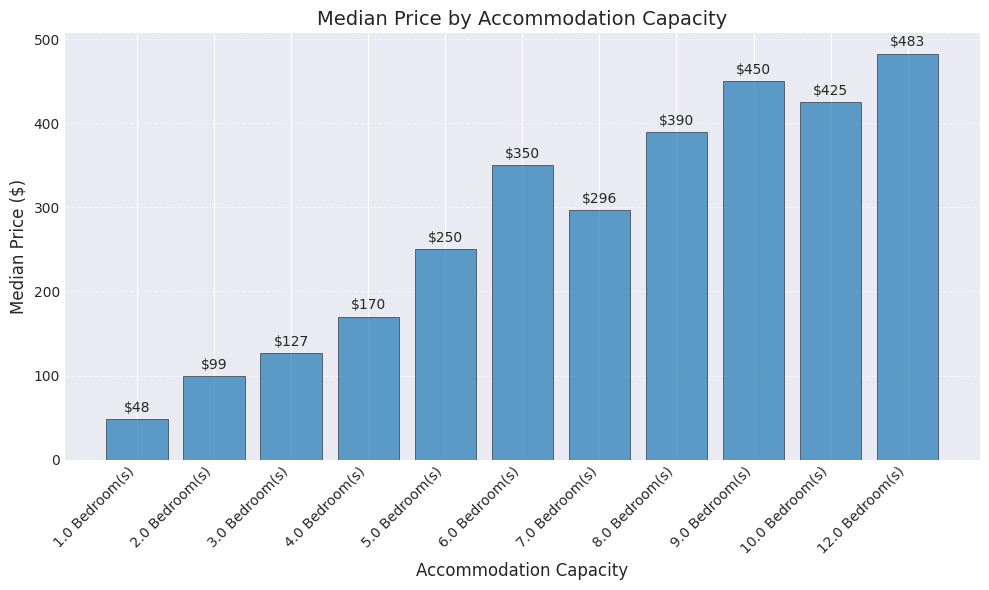

In [23]:
data=listing.groupby('bedrooms')['price'].median()
bedrooms=listing['bedrooms'].apply(str).unique()


plt.figure(figsize=[10, 6])
plt.bar(bedrooms, data.values, alpha=0.7,edgecolor='black',linewidth=0.5)


plt.title('Median Price by Accommodation Capacity', fontsize=14)
plt.xlabel('Accommodation Capacity', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)


plt.xticks(bedrooms, [str(x) + ' Bedroom(s)' for x in data.index], rotation=45, ha='right', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, v in enumerate(data.values):
    plt.text(i, v+5, '${:.0f}'.format(v), ha='center', va='bottom', fontsize=10)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.tight_layout() 
plt.show()

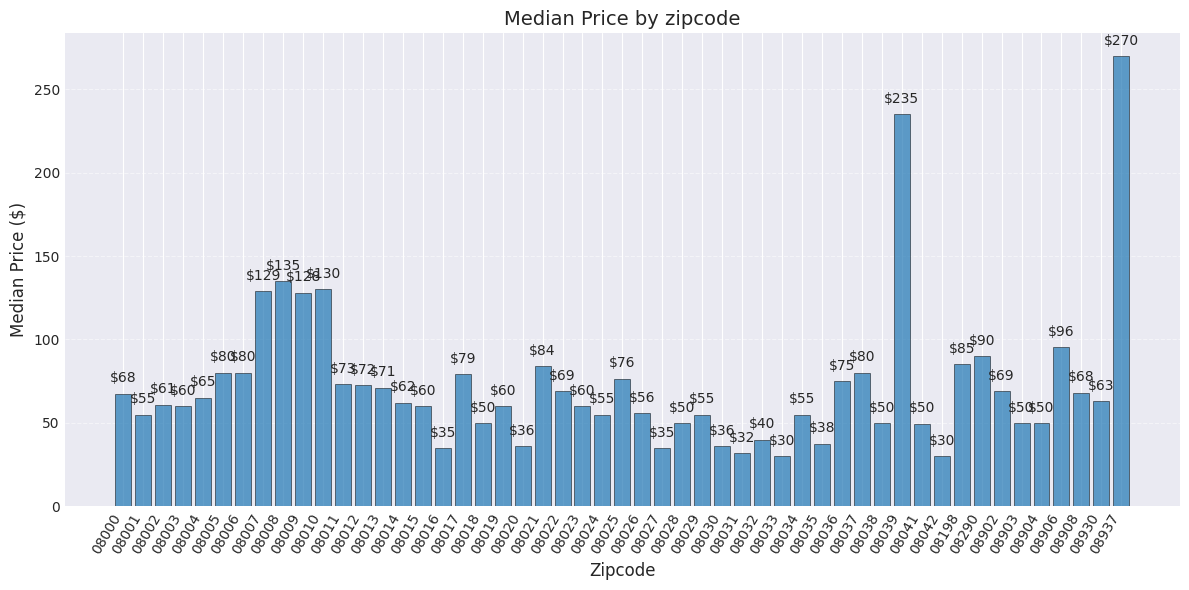

In [24]:
data=listing.groupby('zipcode')['price'].median().reset_index()



plt.figure(figsize=[12, 6])
plt.bar(data['zipcode'], data['price'], alpha=0.7,edgecolor='black',linewidth=0.5)


plt.title('Median Price by zipcode', fontsize=14)
plt.xlabel('Zipcode', fontsize=12)
plt.ylabel('Median Price ($)', fontsize=12)


plt.xticks(ticks=data['zipcode'], rotation=60, ha='right', fontsize=10)


plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, v in enumerate(data['price']):
    plt.text(i, v+5, '${:.0f}'.format(v), ha='center', va='bottom', fontsize=10)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.tight_layout() 
plt.show()


In [27]:
data=listing[['latitude','longitude','neighbourhood']]
def get_information(row):
    return "Price: {}, Room Type: {}, Beds Number: {}".format(row['price'], row['room_type'], row['beds'])

# Apply the get_information function to each row of the DataFrame
data.loc[:,('information')] = listing.loc[:, ('price', 'room_type', 'beds')].apply(get_information, axis=1)

fig = px.scatter_mapbox(data, lat='latitude', lon='longitude', color='neighbourhood',
                         hover_name='information', zoom=4)
fig.update_layout(width=1000, height=800)
# Update map layout and display the figure
fig.update_layout(mapbox_style='carto-positron',
                  mapbox_zoom=11,
                  mapbox_center={'lat': 41.3851, 'lon': 2.1734},
                  width=1000,
                  height = 800)
fig.show()

/tmp/ipykernel_115/3088089918.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Feature Engeneering <a id="section-3"></a>

Building on our previous feature engineering efforts, we now turn our attention to encoding categorical variables. This process involves transforming categorical data into a format that our machine learning models can understand and utilize effectively.

To build our regression model, we are creating a new data frame specifically designed for this purpose.

In [28]:
listing.dtypes

id                         int64
host_id                    int64
host_is_superhost         object
host_listings_count      float64
neighbourhood             object
zipcode                   object
latitude                 float64
longitude                float64
property_type             object
room_type                 object
accommodates               int64
bathrooms                float64
bedrooms                 float64
beds                     float64
amenities                 object
price                    float64
minimum_nights             int64
has_availability          object
availability_30            int64
availability_60            int64
availability_90            int64
availability_365           int64
number_of_reviews_ltm      int64
review_scores_rating      object
price_normal             float64
dtype: object

In [29]:
#looking for non numerical columns
listing[['host_is_superhost', 'neighbourhood', 'zipcode', 'property_type',
       'room_type', 'amenities', 'has_availability', 'review_scores_rating']]

,host_is_superhost,neighbourhood,zipcode,property_type,room_type,amenities,has_availability,review_scores_rating
0,f,Sant Martí,08026,Apartment,Entire home/apt,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",t,80-89
1,f,La Sagrada Família,08025,Apartment,Entire home/apt,"{TV,Internet,Wifi,""Air conditioning"",""Wheelcha...",t,80-89
2,f,Sant Martí,08018,Apartment,Private room,"{TV,Wifi,Kitchen,""Paid parking off premises"",E...",t,90-100
3,t,Sant Martí,08930,Apartment,Entire home/apt,"{TV,Internet,Wifi,""Wheelchair accessible"",Kitc...",t,90-100
4,t,Vila de Gràcia,08012,Apartment,Private room,"{TV,Wifi,""Air conditioning"",Kitchen,""Smoking a...",t,90-100
...,...,...,...,...,...,...,...,...
18424,f,Turó de la Peira - Can Peguera,08031,Bed and breakfast,Private room,"{TV,Wifi,Kitchen,Elevator,Heating,Washer,Dryer...",t,no reviews
18425,f,El Gòtic,08019,Apartment,Private room,"{Wifi,Kitchen,""Free parking on premises"",Heati...",t,no reviews
18426,f,El Poble-sec,08004,Apartment,Private room,"{Wifi,Kitchen,""Smoking allowed"",""Pets allowed""...",t,no reviews
18427,f,Sants-Montjuïc,08004,Apartment,Entire home/apt,"{TV,Wifi,""Air conditioning"",Kitchen,Elevator,H...",t,no reviews


### Observations and Considerations:

- Converting the 'zipcode' column to an integer data type is straightforward. The leading zero may be dropped (e.g., 08026 becomes 8026), but this won't cause issues for machine learning algorithms, so no further action is needed.

- After analyzing the 'amenities' column and separating each service, the correlation with listing price proved to be really low. Including these features may not significantly enhance our model. So we going to drop the column.

- The remaining columns are primarily categorical in nature, and we plan to use label encoding to transform them into a format suitable for our models.

### Transforming Zipcodes

In [30]:
listing_endoced = listing.copy()

In [31]:
listing_endoced['zipcode']= listing_endoced['zipcode'].apply(int)
listing_endoced = listing_endoced.drop(columns='amenities')

### Label Encoding

In [32]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ['host_is_superhost', 'neighbourhood', 'property_type',
       'room_type', 'has_availability', 'review_scores_rating']

for col in categorical_columns:
    labelencoder = LabelEncoder()
    listing_endoced[col] = labelencoder.fit_transform(listing_endoced[col])


listing_endoced

,id,host_id,host_is_superhost,host_listings_count,neighbourhood,zipcode,latitude,longitude,property_type,room_type,...,price,minimum_nights,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews_ltm,review_scores_rating,price_normal
0,18666,71615,0,45.0,54,8026,41.40889,2.18555,1,0,...,130.0,3,0,0,0,0,182,0,6,4.867534
1,18674,71615,0,45.0,32,8025,41.40420,2.17306,1,0,...,60.0,1,0,3,20,50,129,10,6,4.094345
2,21605,82522,0,2.0,54,8018,41.40560,2.19821,1,1,...,33.0,2,0,4,8,15,15,36,7,3.496508
3,23197,90417,1,5.0,54,8930,41.41203,2.22114,1,0,...,210.0,3,0,11,33,63,318,16,7,5.347108
4,25786,108310,1,1.0,65,8012,41.40145,2.15645,1,1,...,45.0,1,0,8,19,41,115,49,7,3.806662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18424,36575390,37032072,0,15.0,62,8031,41.43290,2.16908,3,1,...,16.0,30,0,8,38,68,343,0,8,2.772589
18425,36579000,193399432,0,3.0,15,8019,41.41327,2.21801,1,1,...,30.0,2,0,28,58,88,179,0,8,3.401197
18426,36580710,244397591,0,3.0,16,8004,41.37143,2.16634,1,1,...,55.0,2,0,22,52,82,172,0,8,4.007333
18427,36580899,1447144,0,71.0,57,8004,41.37371,2.16805,1,0,...,125.0,1,0,27,57,86,86,0,8,4.828314


# Training Prediction Model <a id="section-4"></a>

**Through extensive model testing and comparison, I found that the RandomForest Regressor outperformed other models in terms of accuracy and robustness. As a result, this dataset includes only the training of the RandomForest Regressor.**|

In [33]:
from sklearn.model_selection import train_test_split

X = listing_endoced.drop(columns=['id', 'price'])
y = listing['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Random Forest Regressor

Training time for max_depth=1: 0.96 seconds
Training time for max_depth=2: 1.64 seconds
Training time for max_depth=3: 2.33 seconds
Training time for max_depth=4: 2.99 seconds
Training time for max_depth=5: 3.71 seconds
Training time for max_depth=6: 4.36 seconds
Training time for max_depth=7: 5.02 seconds
Training time for max_depth=8: 5.74 seconds
Training time for max_depth=9: 6.41 seconds
Training time for max_depth=10: 6.91 seconds


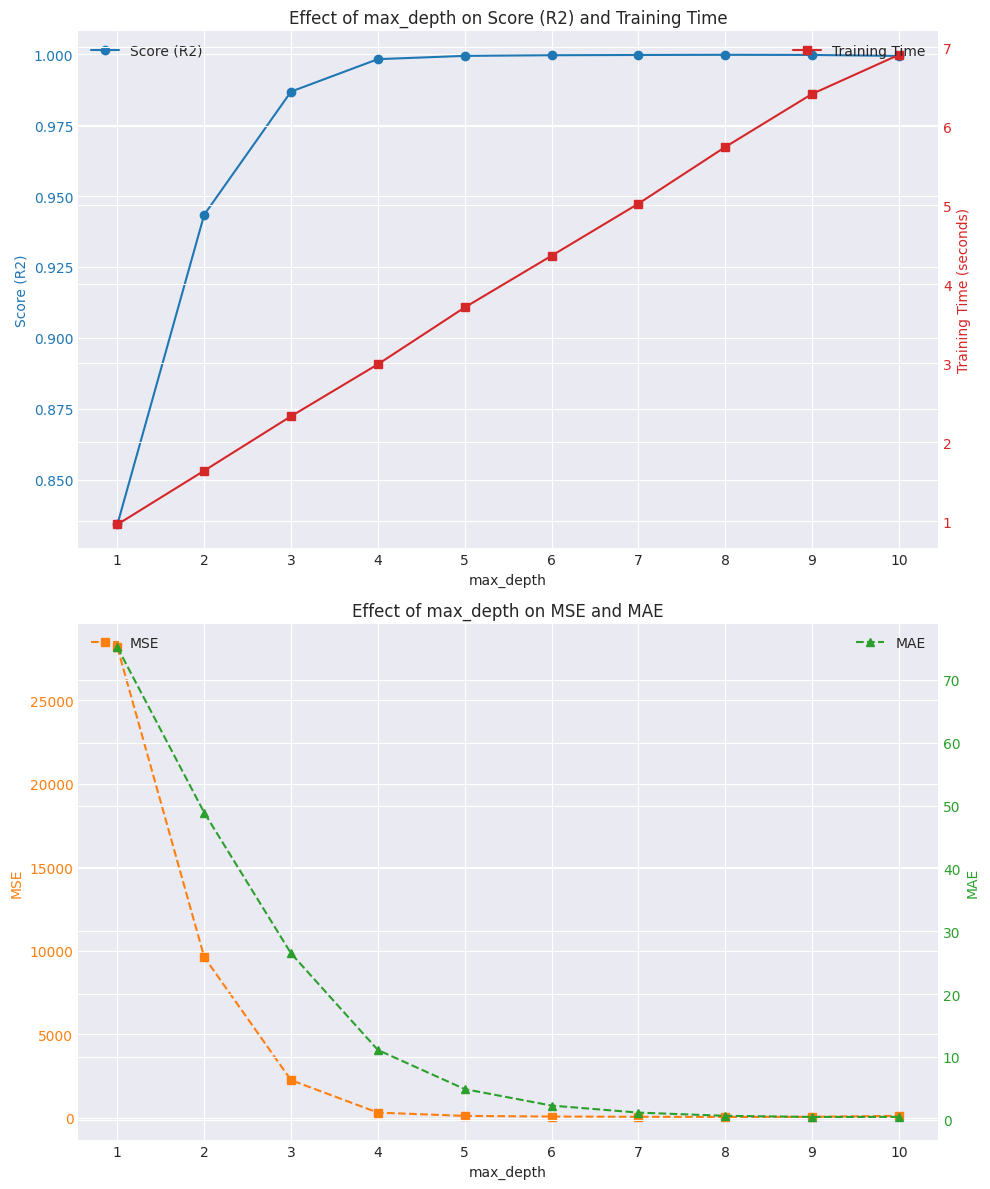

In [45]:
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

max_depth_values = range(1, 11)
training_times = []
scores = []
mse_values = []
mae_values = []

for max_depth in max_depth_values:
    rfr = RandomForestRegressor(max_depth=max_depth, random_state=42)
    
    start_time = time.time()
    rfr.fit(X_train, y_train)
    end_time = time.time() 
    scores.append(rfr.score(X_test, y_test))
    elapsed_time = end_time - start_time  
    training_times.append(elapsed_time)
    
    # Calculate MSE and MAE
    y_pred = rfr.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_values.append(mse)
    mae_values.append(mae)
    
    print(f"Training time for max_depth={max_depth}: {elapsed_time:.2f} seconds")

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot Score and Training Time (Subplot 1)
ax1.plot(max_depth_values, scores, color='tab:blue', marker='o', label='Score (R2)')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Score (R2)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(max_depth_values)

ax1_twin = ax1.twinx()
ax1_twin.plot(max_depth_values, training_times, color='tab:red', marker='s', label='Training Time')
ax1_twin.set_ylabel('Training Time (seconds)', color='tab:red')
ax1_twin.tick_params(axis='y', labelcolor='tab:red')

ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.set_title("Effect of max_depth on Score (R2) and Training Time")

# Plot MSE with Separate Y-axis (Subplot 2)
ax2.plot(max_depth_values, mse_values, color='tab:orange', linestyle='--', marker='s', label='MSE')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_xticks(max_depth_values)

ax2_twin = ax2.twinx()
ax2_twin.plot(max_depth_values, mae_values, color='tab:green', linestyle='--', marker='^', label='MAE')
ax2_twin.set_ylabel('MAE', color='tab:green')
ax2_twin.tick_params(axis='y', labelcolor='tab:green')

ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.set_title("Effect of max_depth on MSE and MAE")

plt.tight_layout()
plt.show()


### Gradient Boosting Regressor

Training time for max_depth=1: 1.18 seconds
Training time for max_depth=2: 2.23 seconds
Training time for max_depth=3: 3.28 seconds
Training time for max_depth=4: 4.34 seconds
Training time for max_depth=5: 5.39 seconds
Training time for max_depth=6: 6.52 seconds
Training time for max_depth=7: 7.53 seconds
Training time for max_depth=8: 8.58 seconds
Training time for max_depth=9: 9.69 seconds
Training time for max_depth=10: 10.47 seconds


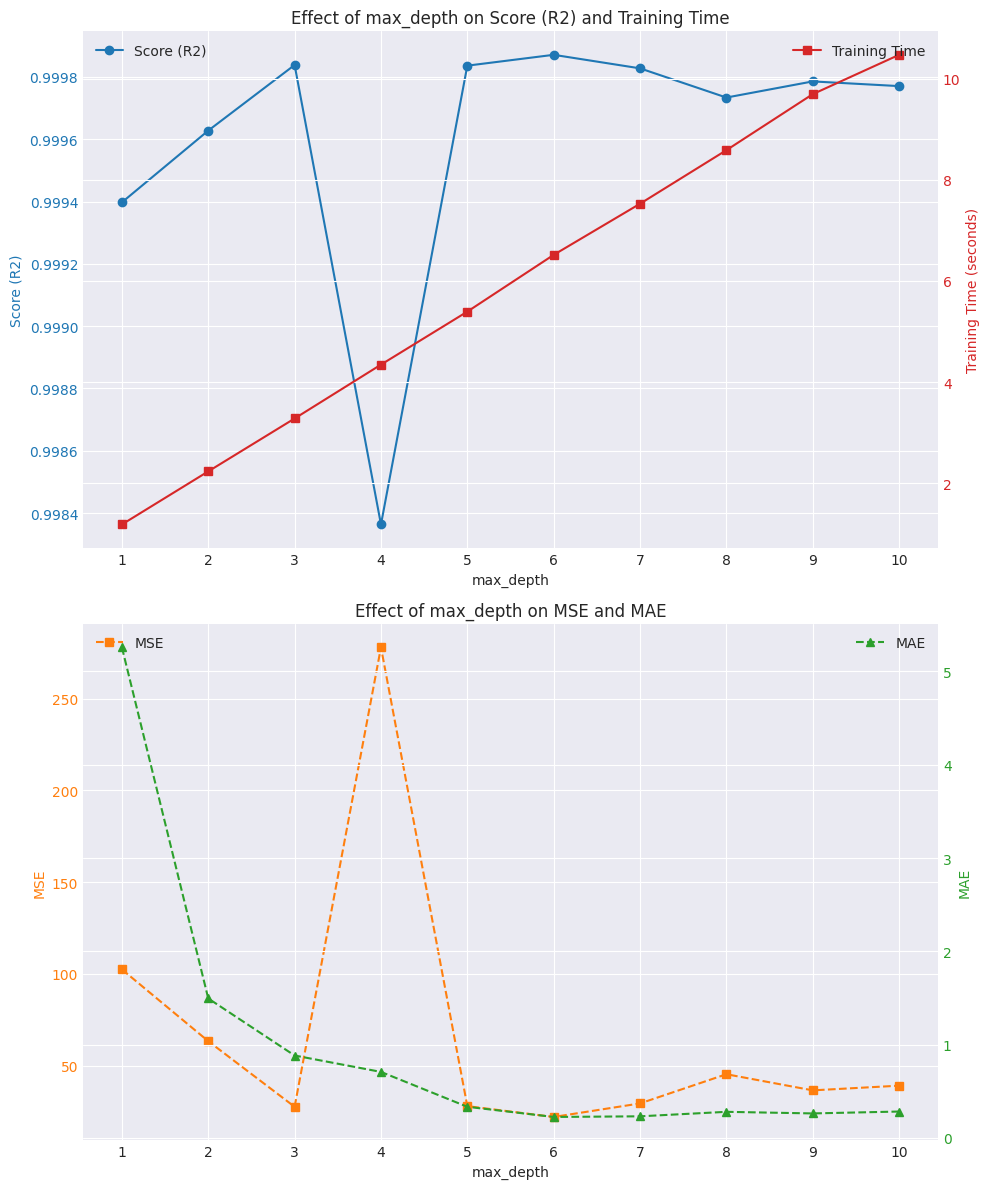

In [46]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor

max_depth_values = range(1, 11)
training_times = []
scores = []
mse_values = []
mae_values = []

for max_depth in max_depth_values:
    xgboost = GradientBoostingRegressor(max_depth=max_depth, random_state=42)
    
    start_time = time.time()
    xgboost.fit(X_train, y_train)
    end_time = time.time() 
    scores.append(xgboost.score(X_test, y_test))
    elapsed_time = end_time - start_time  
    training_times.append(elapsed_time)
    
    # Calculate MSE and MAE
    y_pred = xgboost.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mse_values.append(mse)
    mae_values.append(mae)
    
    print(f"Training time for max_depth={max_depth}: {elapsed_time:.2f} seconds")

# Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot Score and Training Time (Subplot 1)
ax1.plot(max_depth_values, scores, color='tab:blue', marker='o', label='Score (R2)')
ax1.set_xlabel('max_depth')
ax1.set_ylabel('Score (R2)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_xticks(max_depth_values)

ax1_twin = ax1.twinx()
ax1_twin.plot(max_depth_values, training_times, color='tab:red', marker='s', label='Training Time')
ax1_twin.set_ylabel('Training Time (seconds)', color='tab:red')
ax1_twin.tick_params(axis='y', labelcolor='tab:red')

ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.set_title("Effect of max_depth on Score (R2) and Training Time")

# Plot MSE with Separate Y-axis (Subplot 2)
ax2.plot(max_depth_values, mse_values, color='tab:orange', linestyle='--', marker='s', label='MSE')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('MSE', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
ax2.set_xticks(max_depth_values)

ax2_twin = ax2.twinx()
ax2_twin.plot(max_depth_values, mae_values, color='tab:green', linestyle='--', marker='^', label='MAE')
ax2_twin.set_ylabel('MAE', color='tab:green')
ax2_twin.tick_params(axis='y', labelcolor='tab:green')

ax2.legend(loc='upper left')
ax2_twin.legend(loc='upper right')
ax2.set_title("Effect of max_depth on MSE and MAE")

plt.tight_layout()
plt.show()
